# HJB Optimal Pairs Trading Strategy
This notebook computes and visualizes the optimal trading thresholds $(x_0, x_1, x_2)$ for a pairs trading model based on the Ornstein-Uhlenbeck process and the HJB equation.
$$
d Z_t=a\left(b-Z_t\right) d t+\sigma d W_t, Z_0=x
$$

### Implementation notes

We use the identity (Parabolic-cylinder representation)
$$
\int_0^{\infty} t^{\nu-1} e^{-\frac{1}{2} x^2-\mu t} d t= \Gamma(\nu) e^{\mu^2/4} D_{-\nu}\left(\mu\right), \quad \operatorname{Re} (\nu)>0
$$
where $D_\alpha$ is the parabolic cylinder function. Let 
$$
\nu=\frac{\rho}{a}, \quad \kappa=\frac{\sqrt{2 a}}{\sigma}, \quad \mu(x)=\kappa(b-x) .
$$
and define (as in `An Optimal Pairs-Trading Rule`)
$$
\eta(t)=t^{\nu-1} e^{-t^2 / 2}, \quad \phi_1(x)=\int_0^{\infty} \eta(t) e^{-\kappa(b-x) t} d t, \quad \phi_2(x)=\int_0^{\infty} \eta(t) e^{\kappa(b-x) t} d t
$$

Then we obtain
$$
\begin{cases}
\phi_1(x) = \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-\nu}\left(\mu(x)\right), \\
\phi_2(x) = \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-\nu}\left(-\mu(x)\right).
\end{cases}
$$

Differentiating under the integral sign wrt $x$ gives
$$
\begin{cases}
\phi_1'(x)=\kappa  \int_0^{\infty}  t^{\nu} e^{-t^2 / 2} e^{-\kappa(b-x) t} d t =  \kappa \nu \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-(\nu+1)}\left(\mu(x)\right), \\
\phi_2'(x)=-\kappa \int_0^{\infty} t^{\nu}  e^{-t^2 / 2}e^{\kappa(b-x) t} d t =  - \kappa \nu \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-(\nu+1)}\left(-\mu(x)\right).
\end{cases}
$$

These identities are used to determine the threshold by solving the non-linear system,
$$
\begin{cases}
\phi_1(M) P_{1, \uparrow}\left(x_0\right)+\phi_2(M) P_{1, \downarrow}\left(x_0\right)=M-K \\
P_{1, \uparrow}\left(x_1\right)=P_{2, \uparrow}\left(x_2\right) \\
P_{1, \downarrow}\left(x_1\right)=P_{2, \downarrow}\left(x_2\right)
\end{cases}
$$
$$
\begin{array}{ll}
P_{1, \uparrow}(x)=\frac{(x+K) \phi_2^{\prime}(x)-\phi_2(x)}{W(x)}, & P_{1, \downarrow}(x)=\frac{\phi_1(x)-(x+K) \phi_1^{\prime}(x)}{W(x)} \\
P_{2, \uparrow}(x)=\frac{(x-K) \phi_2^{\prime}(x)-\phi_2(x)}{W(x)}, & P_{2, \downarrow}(x)=\frac{\phi_1(x)-(x-K) \phi_1^{\prime}(x)}{W(x)}
\end{array}
$$
which is derived by the boundary condition and smooth pasting for the HJB.

In solving for the thresholds, `map_uvw_to_xs` maps unconstrained optimization variables $u, v, w \in \mathbb{R}$ into bounded regions for numerical stability. We require that 

1. $M < x_1 \leq \frac{a b-\rho K}{\rho+a}$
2. $M<x_0<x_1$
3. $x_2>x_1$ and $x_2 \geq \frac{a b+\rho K}{\rho+a}$

To ensure such inequalities are preserved, `logistic` and `softplus` transformations are applied to ensure that constrained least squares works and converges properly.

In [ ]:
import numpy as np
from scipy.special import pbdv
from scipy.optimize import least_squares
from scipy.special import gamma

EPSILON = 1e-6

def compute_threshold(a = 1.0, sigma = 0.56, rho = 0.1, K = 0.001, b = 0, M = -0.2):
    """
    Computes the threshold values for a given set of parameters.

    Args:
        a (float): The speed of mean reversion.
        sigma (float): The volatility of the underlying asset.
        rho (float): The risk-free rate.
        K (float): The strike price of the option.
        b (float): The long-term mean of the underlying asset.
        M (float): The initial value of the underlying asset.

    Returns:
        tuple: A tuple containing the threshold values (x0, x1, x2).
    """
    # Input Validation
    if a <= 0:
        raise ValueError("Mean reversion speed must be positive.")
    if sigma <= 0:
        raise ValueError("Volatility must be positive.")
    if rho <= 0:
        raise ValueError("Risk-free rate must be positive.")

    nu = rho / a
    kappa = np.sqrt(2 * a) / sigma
    GAM = gamma(nu)
    B1 = (a * b - rho * K) / (rho + a)
    B2 = (a * b + rho * K) / (rho + a)

    # Define auxiliary functions
    def mu(x):
        return kappa * (b - x)

    def phi1(x):
        Dv, _ = pbdv(-nu, mu(x))
        return GAM * np.exp(mu(x) ** 2 / 4.0) * Dv

    def phi2(x):
        Dv, _ = pbdv(-nu, -mu(x))
        return GAM * np.exp(mu(x) ** 2 / 4.0) * Dv

    def dphi1(x):
        Dv, _ = pbdv(-(nu + 1), mu(x))
        return kappa * nu * GAM * np.exp(mu(x) ** 2 / 4.0) * Dv

    def dphi2(x):
        Dv, _ = pbdv(-(nu + 1), -mu(x))
        return -kappa * nu * GAM * np.exp(mu(x) ** 2 / 4.0) * Dv

    def W(x): return phi1(x) * dphi2(x) - dphi1(x) * phi2(x)

    def P1_up(x): return ((x + K) * dphi2(x) - phi2(x)) / W(x)

    def P1_dn(x): return (phi1(x) - (x + K) * dphi1(x)) / W(x)

    def P2_up(x): return ((x - K) * dphi2(x) - phi2(x)) / W(x)

    def P2_dn(x): return (phi1(x) - (x - K) * dphi1(x)) / W(x)

    def logistic(z): return 1.0 / (1.0 + np.exp(-z))

    def softplus(z): return np.log1p(np.exp(z))

    def map_uvw_to_thresholds(u, v, w):
        s1 = logistic(u)
        x1 = M + s1 * (B1 - M)
        s0 = logistic(v)
        x0 = M + s0 * (x1 - M)
        base = max(B2, x1) + EPSILON
        x2 = base + softplus(w)
        return x0, x1, x2

    def residuals_uvw(uvw):
        u, v, w = uvw
        x0, x1, x2 = map_uvw_to_thresholds(u, v, w)
        r1 = phi1(M) * P1_up(x0) + phi2(M) * P1_dn(x0) - (M - K)
        r2 = P1_up(x1) - P2_up(x2)
        r3 = P1_dn(x1) - P2_dn(x2)
        return np.array([r1, r2, r3], dtype=float)

    uvw0 = np.array([0.0, -1.0, 0.0])
    sol = least_squares(residuals_uvw, uvw0, method='trf', ftol=1e-12, xtol=1e-12, gtol=1e-12, max_nfev=20000)

    if not sol.success:
        print("Optimization failed to converge.")
        return None  # Or raise an exception

    u_hat, v_hat, w_hat = sol.x
    x0, x1, x2 = map_uvw_to_thresholds(u_hat, v_hat, w_hat)

    print(f'Parameters: a={a:.2f}, sigma={sigma:.2f}, rho={rho}, K={K}, b={b:.2f}, M={M:.2f}')
    # print(f'Converged to (x_0, x_1, x_2) = ({x0:.3f}, {x1:.3f}, {x2:.3f})')
    print(f'Converged to (x_0, x_1, x_2) = ({x0}, {x1}, {x2})')

    return x0, x1, x2

In [2]:
a, sigma, rho, K, b, M = 1, 0.56, 0.1, 0.001, 0, -0.2

x0, x1, x2 = compute_threshold()

Parameters: a=1.00, sigma=0.56, rho=0.1, K=0.001, b=0.00, M=-0.20
Converged to (x_0, x_1, x_2) = (-0.141, -0.076, 0.076)


In [3]:
# Simulate process

# n_steps = 252 * 1 # Corresponds to n years
n_steps = 252

# Each time step is a single dayr
dt = 1/252 
N_PATH = 4

r = np.zeros((N_PATH, n_steps), dtype=np.float64)
r[:, 0] = b  # start at long-run mean

factor = np.exp(-a*dt)
for col in range(1, n_steps):
    r[:, col] += factor*r[:, col-1] + np.random.normal(loc = b * (1-factor),
                                                       scale = sigma * np.sqrt(0.5 / a * (1 - np.exp(-2 * a*dt))),
                                                       size = N_PATH)

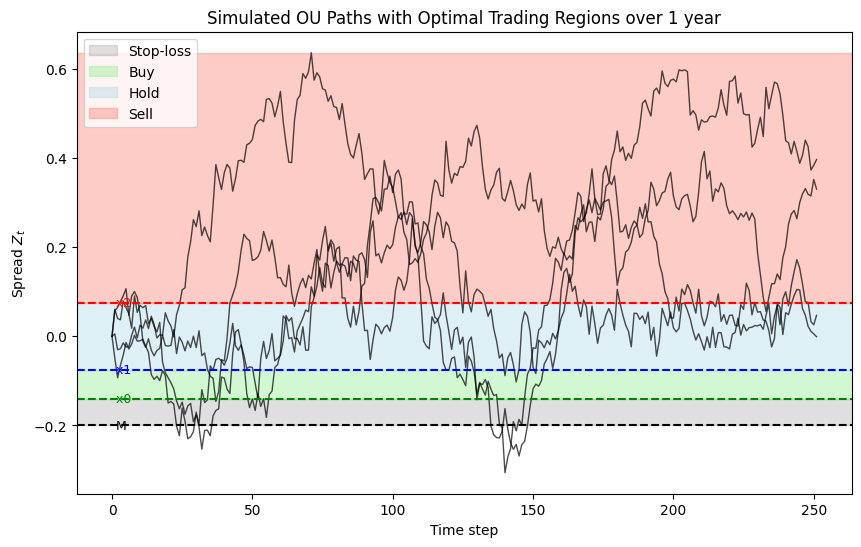

In [ ]:
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(10,6))
for i in range(N_PATH):
    ax.plot(r[i], lw=1, alpha=0.7, color='black')

# Draw regions
ax.axhspan(M, x0, color='gray', alpha=0.25, label='Stop-loss')
ax.axhspan(x0, x1, color='lightgreen', alpha=0.4, label='Buy')
ax.axhspan(x1, x2, color='lightblue', alpha=0.4, label='Hold')
ax.axhspan(x2, max(r.max(), x2+0.05), color='salmon', alpha=0.4, label='Sell')

# Boundaries
for val, col, label in [(M, 'black', 'M'), (x0, 'green', 'x0'), (x1, 'blue', 'x1'), (x2, 'red', 'x2')]:
    ax.axhline(val, color=col, linestyle='--')
    ax.text(0, val, f' {label}', va='center', color=col, fontsize=9)

ax.set_xlabel('Time step')
ax.set_ylabel('Spread $Z_t$')
ax.set_title('Simulated OU Paths with Optimal Trading Regions over 1 year')
ax.legend()
plt.show()

## Monte Carlo Simulation Validation
We simulate multiple Ornstein–Uhlenbeck paths and execute the trading rule defined by $(x_0, x_1, x_2, M)$ to estimate expected profit and variability.

In [5]:

# --- Monte Carlo Simulation for Strategy Performance ---

def simulate_strategy(a, b, sigma, rho, K, M, x0, x1, x2,
                      n_paths=10000, n_steps=252*5, dt=1/252, seed=42):
    np.random.seed(seed)
    profits = []
    
    for _ in range(n_paths):
        Z = np.zeros(n_steps)
        Z[0] = 0  # start at equilibrium
        holding = False
        buy_price = 0.0
        total_profit = 0.0
        
        for t in range(1, n_steps):
            Z[t] = Z[t-1] + a*(b - Z[t-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
            
            if not holding and x0 < Z[t] < x1:
                holding = True
                buy_price = Z[t]
                total_profit -= K  # transaction cost
            
            elif holding:
                if Z[t] > x2:  # sell
                    total_profit += (Z[t] - buy_price) - K
                    holding = False
                elif Z[t] < M:  # stop-loss
                    total_profit += (Z[t] - buy_price) - K
                    holding = False
        
        profits.append(total_profit)
    
    return np.mean(profits), np.std(profits)

mean_profit, std_profit = simulate_strategy(a, b, sigma, rho, K, M, x0, x1, x2)
print(f"Mean profit: {mean_profit:.4f}, Std: {std_profit:.4f}")

Mean profit: 0.0410, Std: 0.5228


### Simulated results

In [16]:
a, b, sigma = 1.0, 0.0, 0.56

n_steps = 252 * 5 # Corresponds to n years

# Each time step is a single day
dt = 1/252 
PATHS = 100000

r = np.zeros((PATHS, n_steps), dtype=np.float64)
r[:, 0] = b  # start at long-run mean (or set your own r0)

factor = np.exp(-a*dt)
for col in range(1, n_steps):
    r[:, col] += factor*r[:, col-1] + np.random.normal(loc = b * (1-factor),
                                                       scale = sigma * np.sqrt(0.5 / a * (1 - np.exp(-2 * a*dt))),
                                                       size = PATHS)

In [17]:
from numba import njit, prange
import numpy as np

@njit
def simulate_one_path(path, x0, x1, x2, M, K):
    capital = 0.0
    holding = False
    for z in path:
        # Buy
        if not holding and (x0 < z < x1):
            holding = True
            capital -= z * (1 + K)
        # Sell
        elif holding and (z > x2 or z < M):
            holding = False
            capital += z * (1 - K)
    return capital

@njit(parallel=True)
def simulate_strategy(paths, x0, x1, x2, M, K):
    n_paths = paths.shape[0]
    res = np.empty(n_paths)
    for i in prange(n_paths):  # parallel loop
        res[i] = simulate_one_path(paths[i], x0, x1, x2, M, K)
    return res

res = simulate_strategy(r, x0, x1, x2, M, K)
print(np.mean(res))
print(np.std(res))

0.08250116054395051
0.5151111821165076


In [18]:
rf = 0.00  # risk-free rate
mean_ret = np.mean(res)
std_ret = np.std(res)

sharpe = (mean_ret - rf) / std_ret if std_ret > 0 else np.nan

print(f"Mean return: {mean_ret:.4f}")
print(f"Volatility:  {std_ret:.4f}")
print(f"Sharpe ratio: {sharpe:.3f}")

win_rate = np.mean(res > 0)
print("Win rate:", win_rate)

Mean return: 0.0825
Volatility:  0.5151
Sharpe ratio: 0.160
Win rate: 0.57307


## Introduction

Crude Oil Brent (CL=F) and Crude Oil WTI (BZ=F) is a correlated pair traded frequently by energy traders. Using daily closing prices from the past 5 years, we fit the OU parameters, compute optimal trading thresholds and backtest the strategy.

### 1. Data Preparation
- Download 5yr historical price data for CL=F/BZ=F pair
- Split into training (2021-2025) and testing (2025 Jan to Present)
- Use Adjusted Close prices if available 

Adjusted Close price is the closing price of a stock adjusted for corporate actions such as dividends, stock splits, and new stock offerings. If these prices are not adjusted, false discontinuities (sudden jumps/drops) are added that are not due to market movement.

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

TICKERS = ["CL=F", "BZ=F"]

# Use 5yrs of data with testing data YTD and training data spanning the previous years
today = date.today()
start_10y = date(today.year - 5, today.month, today.day)   
train_end = date(today.year - 1, 12, 31)                    
test_start = date(today.year, 1, 1) 

raw = yf.download(
    TICKERS,
    start=start_10y,
    end=None,            
    auto_adjust=False,    
    progress=False
)

# Choose Adjusted Close prices if available
if "Adj Close" in raw:
    px = raw["Adj Close"].copy()
elif "Close" in raw:
    px = raw["Close"].copy()
else:
    px = raw.copy()
    
# Renaming columns from tickers to symbols for ease of reading     
rename_map = {"CL=F": "CL", "BZ=F": "BRN"}
px = px.rename(columns=rename_map)

#daily closing prices
px = (
    px.sort_index()
      .resample("1D")    
      .last()
      .ffill()
)

train = px.loc[:str(train_end)].copy()
test  = px.loc[str(test_start):].copy()

### 2. Co-integration test

Run OLS regression
$$C L_t=\alpha+\beta \times B R N_t+\varepsilon_t$$
to rearrange and obtain the residual
$$Z_t:=\varepsilon_t=C L_t-(\alpha+\beta \times B R N_t)$$
and perform ADF test on $Z_t$ to confirm stationarity.

In [52]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint

X = sm.add_constant(train["BRN"])         # adding intercept
ols = sm.OLS(train["CL"], X).fit()
alpha = float(ols.params["const"])
beta  = float(ols.params["BRN"])
print(alpha, beta)

eps = train["CL"] - (alpha + beta*train["BRN"])

adf_stat, pval, *_ = adfuller(eps.dropna(), autolag="AIC")
print("ADF p-value on residuals:", pval)

t_stat, p_coint, crit = coint(train["CL"], train["BRN"], trend="c", autolag="AIC")
print("EG p-value:", p_coint)

-1.836520284654986 0.9734612295142488
ADF p-value on residuals: 0.0720842439774981
EG p-value: 0.1952477691463868


### 3. Calibration of OU parameters

If $Z_t$ is stationary, it is reasonable to model it as an OU process:
$$
d Z_t=a\left(b-Z_t\right) d t+\sigma d W_t, Z_0=x
$$
Estimate $a, b, \sigma$ by fitting an AR(1) model on the discrete observations:
$$
Z_t = c+\phi Z_{t-1}+\epsilon_t, \quad \epsilon_t \sim N(0, \hat{\sigma}^2)
$$
Convert AR(1) parameters to daily OU parameters using the following relations
$$a_{\text{daily}}=-\log(\phi), \quad b =\frac{c}{1-\phi}, \quad \sigma_{\text{daily}}=\hat{\sigma} \sqrt{\frac{2 \theta}{1-\phi^2}}$$
and annualize by the following (long-term mean $b$ remains unchanged):
$$a=a_{\text{daily}} \times 252, \quad \sigma=\sigma_{\text{daily}} \times \sqrt{252}$$

In [ ]:
import numpy as np
import statsmodels.api as sm

eps = eps.dropna()
eps_lag = eps.shift(1).dropna()
eps = eps.loc[eps_lag.index]

X = sm.add_constant(eps_lag)
ar1 = sm.OLS(eps, X).fit()
c, phi = ar1.params
print(f"AR(1) parameters: c={c:.6f}, phi={phi:.6f}")

a_daily = -np.log(phi)
b = c / (1 - phi)
sigma_hat = np.std(ar1.resid)
sigma_daily = sigma_hat * np.sqrt(2 * a_daily / (1 - phi**2))

a = a_daily * 252
sigma = sigma_daily * np.sqrt(252)

print(f"OU parameters: a_daily={a_daily:.6f}, b={b:.6f}, sigma_daily={sigma_daily:.6f}")
print(f"Annualized OU parameters: a={a:.6f}, b={b:.6f}, sigma={sigma:.6f}")

AR(1) parameters: c=-0.000236, phi=0.942930
OU parameters: a=0.058763, b=-0.004141, sigma=0.522218
Annualized OU parameters: a=14.808212, b=-0.004141, sigma=8.289950


### 4. Obtain optimal trading thresholds

In this step, it is important to choose an appropriate stop-loss value $M$ which can be difficult to choose heuristically. 
This should be done with reference to the spread profile (which cannot be generalised and has to be manually selected).

In [ ]:
rho, M = 0.1, -3
x0, x1, x2 = compute_threshold(a, sigma, rho, K, b, M)

Parameters: a=14.81, sigma=8.29, rho=0.1, K=0.001, b=-0.00, M=-3.00
Converged to (x_0, x_1, x_2) = (-2.944837480734485, -0.194827450095429, 0.1866007617621444)


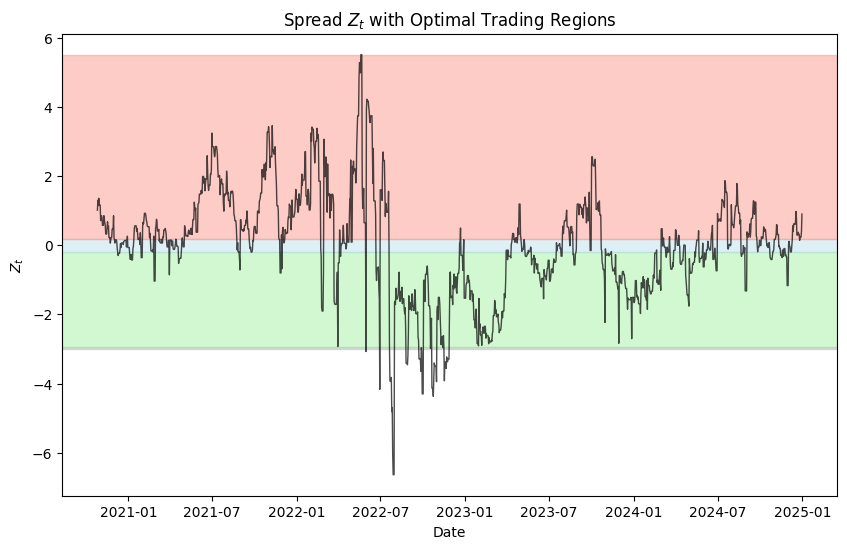

In [ ]:
# Plot eps with the thresholds
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(eps.index, eps.values, lw=1, alpha=0.7,
        color='black', label='Residuals (Spread)')
ax.axhspan(M, x0, color='gray', alpha=0.25, label='Stop-loss')
ax.axhspan(x0, x1, color='lightgreen', alpha=0.4, label='Buy')
ax.axhspan(x1, x2, color='lightblue', alpha=0.4, label='Hold')
ax.axhspan(x2, max(eps.max(), x2+0.05), color='salmon', alpha=0.4, label='Sell')

ax.set_title('Spread $Z_t$ with Optimal Trading Regions')
ax.set_xlabel('Date')
_ = ax.set_ylabel('$Z_t$')

### 5. Backtesting

In [ ]:
import numpy as np
import pandas as pd

def backtest_band_rule(
    eps: pd.Series,
    x0: float, x1: float,   # entry band (enter when eps ∈ (x0, x1))
    M: float, x2: float,    # exit thresholds (exit when eps <= M or eps >= x2)
    direction: int = 1,     # +1 = long when inside (x0,x1); -1 = short when inside
    cost_per_turn: float = 0.0
):
    """
    Backtest rule:
    - Enter when eps is inside (x0, x1)
    - Exit when eps <= M or eps >= x2
    direction: +1 for long, -1 for short
    """
    eps = eps.dropna().copy()
    n = len(eps)
    pos = np.zeros(n, dtype=int)

    for i in range(1, n):
        prev_pos = pos[i-1]
        e = eps.iloc[i]

        if prev_pos == 0:
            # Entry condition
            if x0 < e < x1:
                pos[i] = direction
            else:
                pos[i] = 0
        else:
            # Exit condition
            if e <= M or e >= x2:
                pos[i] = 0
            else:
                pos[i] = prev_pos

    pos = pd.Series(pos, index=eps.index, name="position")
    d_eps = eps.diff().fillna(0)
    gross = (pos.shift(1).fillna(0) * d_eps).rename("gross_pnl")

    turns = pos.diff().abs().fillna(0)
    costs = (turns > 0).astype(float) * cost_per_turn
    net = gross - costs
    cum_pnl = net.cumsum()

    stats = {
        "trades": int((turns > 0).sum()),
        "avg_daily_pnl": float(net.mean()),
        "std_daily_pnl": float(net.std(ddof=1)),
        "sharpe_252": float((np.sqrt(252) * net.mean() / (net.std(ddof=1) + 1e-12))),
        "max_drawdown": float((cum_pnl.cummax() - cum_pnl).max()),
    }

    return pd.DataFrame({
        "eps": eps, "position": pos, "d_eps": d_eps,
        "gross_pnl": gross, "net_pnl": net, "cum_pnl": cum_pnl
    }), stats

{'trades': 64, 'avg_daily_pnl': 0.009994175571667525, 'std_daily_pnl': 0.2852083394685858, 'sharpe_252': 0.5562692136756852, 'max_drawdown': 12.366627599453537}


<Axes: title={'center': 'Cumulative PnL (Band Rule Backtest)'}, xlabel='Date'>

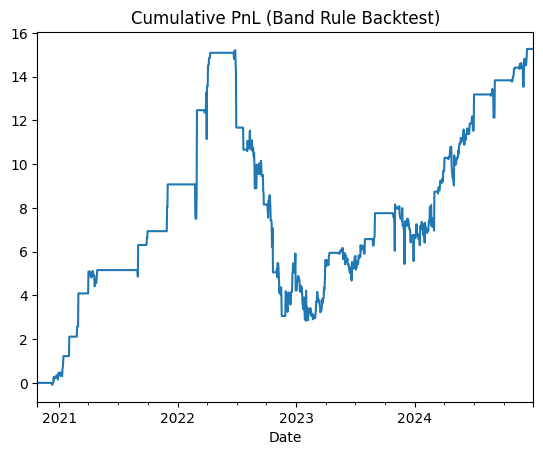

In [ ]:
res, stats = backtest_band_rule(
    eps,
    x0, x1,
    M, x2,
    direction=1,
    cost_per_turn=0.001
)

print(stats)
res["cum_pnl"].plot(title="Cumulative PnL (Band Rule Backtest)")

### 6. Other baseline algorithms for comparison